In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from tensorflow import keras
from nltk.stem.snowball import RomanianStemmer
from unidecode import unidecode

In [2]:
df = pd.read_csv("../data/ro_news.csv")
df.head()

,source,title,text,url
0,evz.ro,Ministrul spulberă informațiile despre pensii....,Ministrul Muncii Violeta Alexandru a declarat ...,https://evz.ro/bomba-despre-pensii-ministrul-s...
1,adevarul.ro,G4Media: Klaus Iohannis i-a cerut premierului ...,"Preşedintele Klaus Iohannis i-a cerut, vineri,...",https://adevarul.ro/news/politica/g4media-klau...
2,puterea.ro,ULTIMA ORĂ: Medicul Mircea Beuran a fost REȚIN...,Medicul Mircea Beuran a fost reținut pentru 24...,https://www.puterea.ro/eveniment/ultima-ora-me...
3,agerpres.ro,"Iohannis, în Israel: România - angajată să con...","\r\nTrimisul special al AGERPRES, Florentina P...",https://www.agerpres.ro/politica/2020/01/21/io...
4,news.ro,Avertizări cod galben şi cod portocaliu de plo...,Meteorologii au emis saâmbătă seară avertizări...,https://www.news.ro/social/avertizari-cod-galb...


In [3]:
df['y'] = df['source'].apply(lambda x: x in ('puterea.ro', 'b1.ro')).astype(int)

In [4]:
def clean(txt):
    tokens = word_tokenize(txt)
    stemmer = RomanianStemmer()
    # remove all tokens that are not alphabetic
    words = [stemmer.stem(unidecode(word.lower())) for word in tokens if word.isalpha()]
    return words

In [5]:
%%time
df['title_clean'] = df['title'].apply(clean)
df['text_clean'] = df['text'].apply(clean)

Wall time: 4min 46s


In [7]:
def get_vocabulary(X):
    chars_ = set()
    for sent in X:
        for w in sent:
            for c in w:
                chars_.add(c)
    chars_ = sorted(list(chars_))
    char2idx = { c : i + 1 for i, c in enumerate(chars_)}
    return char2idx

def get_char_features(X, char2idx, sent_size=100, char_feat_size=10):
    def word2charidxs(word, char2idx):
        char_feats = list(map(lambda c : char2idx.get(c, 0), word))
        return char_feats
    
    X_chars = []
    for sent in X:
        sent_indx = list(map(lambda x: word2charidxs(x, char2idx), sent))
        sent_indx = keras.preprocessing.sequence.pad_sequences(maxlen=char_feat_size,
            sequences=sent_indx, padding="post", truncating="post", value=0)
        X_chars.append(sent_indx)
    pad_val = np.zeros((sent_size, char_feat_size))
    X_chars = keras.preprocessing.sequence.pad_sequences(maxlen=sent_size, sequences=X_chars,
        padding="post", truncating="post", value = pad_val)
    return X_chars

In [8]:
%%time
title_char2idx = get_vocabulary(df['title_clean'])
text_char2idx = get_vocabulary(df['text_clean'])

Wall time: 1.77 s


In [9]:
%%time
X_title = get_char_features(df['title_clean'], title_char2idx)
X_text = get_char_features(df['text_clean'], text_char2idx)

Wall time: 27.2 s


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

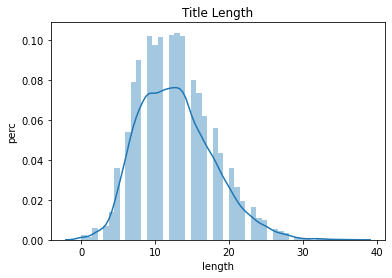

In [23]:
fig, ax = plt.subplots(1)
sns.distplot(df['title_clean'].apply(lambda x: len(x)), ax=ax)
ax.set_title('Title Length')
ax.set_xlabel('length')
ax.set_ylabel('perc')
plt.show()

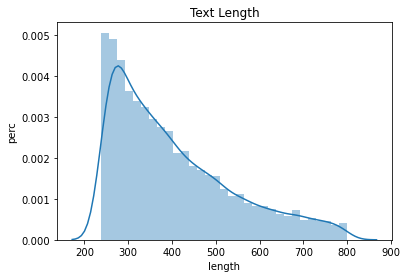

In [25]:
fig, ax = plt.subplots(1)
aux_series = df['text_clean'].apply(lambda x: len(x))
aux_series = aux_series[aux_series.between(aux_series.quantile(.5), aux_series.quantile(.95))]
sns.distplot(aux_series, ax=ax)
ax.set_title('Text Length')
ax.set_xlabel('length')
ax.set_ylabel('perc')
plt.show()

In [11]:
# char encoding
SENT_SIZE = 100
CHAR_FEAT_SIZE = 10

def title_only_model(char2idx):
    # TITLE INPUT
    title_input = keras.layers.Input(shape=(SENT_SIZE, CHAR_FEAT_SIZE))
    title_char_emb = keras.layers.TimeDistributed(keras.layers.Embedding(input_dim=len(char2idx) + 1,
        output_dim=30, input_length=CHAR_FEAT_SIZE))(title_input)  

    title_char_dropout = keras.layers.Dropout(0.5)(title_char_emb)
    title_char_conv1d = keras.layers.TimeDistributed(keras.layers.Conv1D(kernel_size=3, filters=32,
        padding='same',activation='tanh', strides=1))(title_char_dropout)
    title_char_maxpool = keras.layers.TimeDistributed(keras.layers.MaxPooling1D(CHAR_FEAT_SIZE))(title_char_conv1d)
    title_char_feats = keras.layers.TimeDistributed(keras.layers.Flatten())(title_char_maxpool)

    #all_feat = keras.layers.concatenate([char_feats])
    all_feat = title_char_feats

    all_out = keras.layers.SpatialDropout1D(0.3)(all_feat)

    bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(units=100,
            return_sequences=False))(all_out)

    out = keras.layers.Dense(1, activation="sigmoid")(bi_lstm)

    model = keras.models.Model([title_input], out)
    model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['acc'])

    return model



def title_and_text_model(title_char2idx, text_char2idx):
    # TITLE INPUT
    title_input = keras.layers.Input(shape=(SENT_SIZE, CHAR_FEAT_SIZE))
    title_char_emb = keras.layers.TimeDistributed(keras.layers.Embedding(input_dim=len(title_char2idx) + 1,
        output_dim=30, input_length=CHAR_FEAT_SIZE))(title_input)  

    title_char_dropout = keras.layers.Dropout(0.5)(title_char_emb)
    title_char_conv1d = keras.layers.TimeDistributed(keras.layers.Conv1D(kernel_size=3, filters=32,
        padding='same',activation='tanh', strides=1))(title_char_dropout)
    title_char_maxpool = keras.layers.TimeDistributed(keras.layers.MaxPooling1D(CHAR_FEAT_SIZE))(title_char_conv1d)
    title_char_feats = keras.layers.TimeDistributed(keras.layers.Flatten())(title_char_maxpool)
    
    # TEXT INPUT
    text_input = keras.layers.Input(shape=(SENT_SIZE, CHAR_FEAT_SIZE))
    text_char_emb = keras.layers.TimeDistributed(keras.layers.Embedding(input_dim=len(text_char2idx) + 1,
        output_dim=30, input_length=CHAR_FEAT_SIZE))(text_input)  

    text_char_dropout = keras.layers.Dropout(0.5)(text_char_emb)
    text_char_conv1d = keras.layers.TimeDistributed(keras.layers.Conv1D(kernel_size=3, filters=32,
        padding='same',activation='tanh', strides=1))(text_char_dropout)
    text_char_maxpool = keras.layers.TimeDistributed(keras.layers.MaxPooling1D(CHAR_FEAT_SIZE))(text_char_conv1d)
    text_char_feats = keras.layers.TimeDistributed(keras.layers.Flatten())(text_char_maxpool)
    
    all_feat = keras.layers.concatenate([title_char_feats, text_char_feats])

    all_out = keras.layers.SpatialDropout1D(0.3)(all_feat)

    bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(units=100,
            return_sequences=False))(all_out)

    out = keras.layers.Dense(1, activation="sigmoid")(bi_lstm)

    model = keras.models.Model([title_input, text_input], out)
    model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['acc'])

    return model


In [12]:
y = df['y'].values

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

df['title_joined'] = df['title_clean'].apply(lambda x: ' '.join(x))
df['text_joined'] = df['text_clean'].apply(lambda x: ' '.join(x))


In [14]:
df['svm_input'] = df.apply(lambda r: r['title_joined'] + ' ' + r['text_joined'], axis=1)

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,2))
SVM_input = vectorizer.fit_transform(df['svm_input'])


In [15]:
SVM_input

<19626x701 sparse matrix of type '<class 'numpy.float64'>'
	with 3911909 stored elements in Compressed Sparse Row format>

In [16]:
from sklearn.svm import SVC

In [18]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(SVM_input, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [19]:
y_hat = svm.predict(SVM_input)

In [22]:
metrics.classification_report(y, y_hat, output_dict=True)

{'0': {'precision': 0.8876954667509083,
  'recall': 0.9999406915366823,
  'f1-score': 0.9404808389579964,
  'support': 16861},
 '1': {'precision': 0.9984202211690363,
  'recall': 0.22857142857142856,
  'f1-score': 0.37198351971748084,
  'support': 2765},
 'accuracy': 0.8912666870477938,
 'macro avg': {'precision': 0.9430578439599723,
  'recall': 0.6142560600540554,
  'f1-score': 0.6562321793377386,
  'support': 19626},
 'weighted avg': {'precision': 0.9032948729450447,
  'recall': 0.8912666870477938,
  'f1-score': 0.8603883551253241,
  'support': 19626}}

In [56]:
title_model = title_only_model(title_char2idx)

In [18]:
title_model.fit(x=X_title, y=y, batch_size=32, epochs=10, validation_split=.1)

Train on 17663 samples, validate on 1963 samples
Epoch 1/10
17663/17663 [==============================] - 9s 503us/sample - loss: 0.4094 - acc: 0.8576 - val_loss: 0.3936 - val_acc: 0.8630
Epoch 2/10
17663/17663 [==============================] - 6s 315us/sample - loss: 0.3952 - acc: 0.8607 - val_loss: 0.3977 - val_acc: 0.8630
Epoch 3/10
17663/17663 [==============================] - 6s 314us/sample - loss: 0.3895 - acc: 0.8613 - val_loss: 0.3897 - val_acc: 0.8645
Epoch 4/10
17663/17663 [==============================] - 6s 314us/sample - loss: 0.3885 - acc: 0.8621 - val_loss: 0.3875 - val_acc: 0.8635
Epoch 5/10
17663/17663 [==============================] - 6s 314us/sample - loss: 0.3858 - acc: 0.8621 - val_loss: 0.3948 - val_acc: 0.8625
Epoch 6/10
17663/17663 [==============================] - 6s 317us/sample - loss: 0.3847 - acc: 0.8626 - val_loss: 0.3958 - val_acc: 0.8645
Epoch 7/10
17663/17663 [==============================] - 6s 318us/sample - loss: 0.3824 - acc: 0.8627 - val_lo

In [23]:
text_model = title_and_text_model(title_char2idx, text_char2idx)

In [24]:
text_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 10)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 10)]    0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 100, 10, 30)  810         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 100, 10, 30)  810         input_2[0][0]                    
______________________________________________________________________________________________

In [29]:
hist = text_model.fit(x=[X_title, X_text], y=y, batch_size=32, epochs=3, validation_split=.2)

Train on 15700 samples, validate on 3926 samples
Epoch 1/3
15700/15700 [==============================] - 60s 4ms/sample - loss: 0.3704 - acc: 0.8771 - val_loss: 0.3509 - val_acc: 0.8821
Epoch 2/3
15700/15700 [==============================] - 57s 4ms/sample - loss: 0.3370 - acc: 0.8889 - val_loss: 0.3470 - val_acc: 0.8821
Epoch 3/3
15700/15700 [==============================] - 54s 3ms/sample - loss: 0.3280 - acc: 0.8900 - val_loss: 0.3386 - val_acc: 0.8821


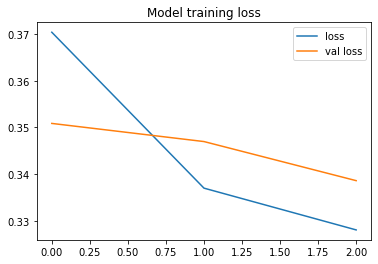

In [43]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title('Model training loss')
plt.legend()

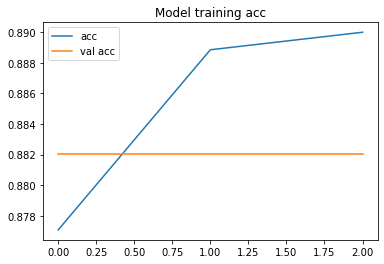

In [44]:
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['val_acc'], label='val acc')
plt.title('Model training acc')
plt.legend()

In [84]:
import pickle

In [85]:
with open('char2idxs.pkl', 'wb') as f:
    pickle.dump({'text_char2idx' : text_char2idx,
        'title_char2idx' : title_char2idx,
    }, f)

In [86]:
text_model.save_weights('../model.h5')

In [50]:
y_hat = text_model.predict([X_title, X_text])

In [56]:
y_hat = np.round(y_hat).astype(int).flatten()

In [21]:
import sklearn.metrics as metrics

In [62]:
f1 = metrics.f1_score(y, y_hat)

In [63]:
f1

0.34538392590379446

In [70]:
metrics.classification_report(y, y_hat, output_dict=True)

{'0': {'precision': 0.8851606805293005,
  'recall': 0.9997627661467291,
  'f1-score': 0.9389778582370143,
  'support': 16861},
 '1': {'precision': 0.993127147766323,
  'recall': 0.20904159132007233,
  'f1-score': 0.34538392590379446,
  'support': 2765},
 'accuracy': 0.8883623764394171,
 'macro avg': {'precision': 0.9391439141478117,
  'recall': 0.6044021787334007,
  'f1-score': 0.6421808920704044,
  'support': 19626},
 'weighted avg': {'precision': 0.9003714867002149,
  'recall': 0.8883623764394171,
  'f1-score': 0.8553496495902522,
  'support': 19626}}

In [66]:
all_

'              precision    recall  f1-score   support\n\n           0       0.89      1.00      0.94     16861\n           1       0.99      0.21      0.35      2765\n\n    accuracy                           0.89     19626\n   macro avg       0.94      0.60      0.64     19626\nweighted avg       0.90      0.89      0.86     19626\n'

In [67]:
type(all_)

str